# MTA EDA

The following notebook investigates the MTA data for the month of September 2018. 

Our investigation takes a two-pronged approach:

**1. To maximize the number of people attending the gala and**  
**2. To effectively target people that will likely be a part of our client's cause- Women Tech Women Yes.**


Since we have scarce resources, we can only target so many stations before the gala. Thus, we will target the top ten stations in our analyses ordered by traffic.  We will then find the optimal times to go to these stations based on the busiest times.  

In order to tackle the second problem, we will attempt to correlate our station data with corresponding zip codes, and find areas of high income, female-to-male ratio, and age (older people are likely to have more money to donate and give back to their communities). 

Let's start my importing libraries to enable us to make pretty plots and read in the data set. 

In [1]:

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (5, 3)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['grid.color'] = '#eeeeee'

rcParams['axes.facecolor'] = '#eeeeee'
#rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 10
rcParams['patch.edgecolor'] = 'none'

In [2]:
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

## Collecting the data

In [3]:
def get_data(week_nums):
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

Use September 2018 data since the gala is on October 1st

In [12]:
combined_df = get_data([180901,180908,180915, 180922])

## Clean the Data

In [13]:
#reindex things so they are contiguous
combined_df.index = range(len(combined_df.index))

In [14]:
#remove white spaces and make everything lower case for columns names
combined_df.columns = [col.lower().strip() for col in combined_df.columns]

Let's check out the header of our data to get a taste of what we'll be working with. 

In [15]:
combined_df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,00:00:00,REGULAR,6736067,2283184
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,04:00:00,REGULAR,6736087,2283188
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,08:00:00,REGULAR,6736105,2283229
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,12:00:00,REGULAR,6736180,2283314
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,16:00:00,REGULAR,6736349,2283384


Hmm... I notice that one of the columns, 'desc', has an entry 'REGULAR'... I'm curious what the other values may be. 

In [16]:
combined_df.desc.value_counts()

REGULAR       786725
RECOVR AUD      3652
Name: desc, dtype: int64

It seems like it represent incorrectly inputted entries of some sort... since it only makes up about 0.4% of the data, let's get rid of these entries.  

In [17]:
combined_df = combined_df[combined_df.desc == 'REGULAR']

Drop the 'desc' column now that have already filtered using it. 

In [18]:
combined_df = combined_df.drop(['desc'], axis = 1)

Since the entries and exits represent the accumulative entries and exits, let's use the diff() function to find the net entries and exits in a given time period. 

In [19]:
combined_df[['entries', 'exits']] = combined_df.groupby(["unit", "scp"]).diff()

Let's split our entries into morning and afternoon entries. This will be useful when we integrate demographic information per zip code in our analysis. 

In [20]:
combined_df['morning'] = np.where(combined_df.time <= '12:00:00', 1, 0)
combined_df['morning_entries'] = combined_df.morning * combined_df.entries
combined_df['afternoon_entries'] = combined_df.entries - combined_df.morning_entries

In [21]:
combined_df.head()

,c/a,unit,scp,station,linename,division,date,time,entries,exits,morning,morning_entries,afternoon_entries
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,00:00:00,NaN,NaN,1,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,04:00:00,20.0,4.0,1,20.0,0.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,08:00:00,18.0,41.0,1,18.0,0.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,12:00:00,75.0,85.0,1,75.0,0.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,16:00:00,169.0,70.0,0,0.0,169.0


Since the diff() function creates NAs for the first entry of each turnstile, we can set it to 0 with the fillna() function.

In [22]:
combined_df = combined_df.fillna(0)

Let's look at some basic summary statistics of the numerical features in our data frame. 

In [23]:
combined_df.entries.describe()

count    7.867250e+05
mean    -8.036505e+02
std      7.960072e+05
min     -7.046758e+08
25%      8.000000e+00
50%      6.800000e+01
75%      2.250000e+02
max      3.221676e+07
Name: entries, dtype: float64

In [24]:
combined_df.exits.describe()

count    7.867250e+05
mean    -6.045156e+02
std      5.878356e+05
min     -5.201709e+08
25%      7.000000e+00
50%      4.900000e+01
75%      1.560000e+02
max      2.318928e+07
Name: exits, dtype: float64

Using the describe function, we are running into some errors with the negative values- let's take the absolute values of these to make it more sensible since it is likely that the turnstile was programmed incorrectly such that it decremented rather than incremented. 

In [25]:
combined_df['entries'] = abs(combined_df['entries'])

In [26]:
combined_df['exits'] = abs(combined_df['exits'])

In [27]:
combined_df.describe()

,entries,exits,morning,morning_entries,afternoon_entries
count,7.867250e+05,7.867250e+05,786725.000000,7.867250e+05,7.867250e+05
mean,1.385706e+03,1.065766e+03,0.587374,-9.092782e+02,1.056277e+02
std,7.960064e+05,5.878349e+05,0.492307,7.950230e+05,3.956981e+04
min,0.000000e+00,0.000000e+00,0.000000,-7.046758e+08,-5.877814e+06
25%,9.000000e+00,8.000000e+00,0.000000,0.000000e+00,0.000000e+00
50%,7.000000e+01,5.000000e+01,1.000000,0.000000e+00,0.000000e+00
75%,2.290000e+02,1.580000e+02,1.000000,4.900000e+01,1.040000e+02
max,7.046758e+08,5.201709e+08,1.000000,1.138716e+06,3.221676e+07


Some of these maximum values are completely unreasonable and will distort our analysis. 

In order to fix this problem, we'll get rid of all of the  values for entries and exits and all of values larger than 3000. The exact threshold was somewhat arbitrary, but I messed with the threshold until it gave me belieavable maximum values.

How did I determine what is believable?

Well, the busiest subway in NYC (based on a quick Google search) has an annual ridership of 64 million, which is equivalent to 64000000 / 365 / 24 ~ 7000 riders per hour at a specific station. Thus, anything above a few thousand or so for a specific turnstile is likely an error.

In [28]:
combined_df = combined_df[combined_df.entries < 3000]
combined_df = combined_df[combined_df.exits < 3000]


In [29]:
combined_df.describe()

,entries,exits,morning,morning_entries,afternoon_entries
count,786362.000000,786362.000000,786362.000000,786362.00000,786362.000000
mean,168.697342,130.486014,0.587455,66.74013,96.955800
std,247.764446,218.157728,0.492293,168.02452,218.538602
min,0.000000,0.000000,0.000000,-2775.00000,-2255.000000
25%,9.000000,8.000000,0.000000,0.00000,0.000000
50%,70.000000,50.000000,1.000000,0.00000,0.000000
75%,229.000000,158.000000,1.000000,49.00000,104.000000
max,2995.000000,2999.000000,1.000000,2995.00000,2967.000000


Let's also include datetime object that includes the date and times in our dataframe to perform time series analysis. 

In [30]:
from datetime import datetime as dt

In [31]:
combined_df["date_time"] = pd.to_datetime(combined_df.date + " " + \
                                          combined_df.time, \
                                          format="%m/%d/%Y %H:%M:%S")

In [32]:
combined_df.date_time.value_counts().tail()

2018-09-05 05:52:56    1
2018-09-16 13:00:34    1
2018-09-09 08:39:17    1
2018-09-01 22:16:31    1
2018-09-09 19:01:41    1
Name: date_time, dtype: int64

In [33]:
len(combined_df[combined_df.time.apply(lambda x:x[-2:]) != '00'])

57940

In [34]:
len(combined_df[combined_df.time.apply(lambda x:x[-2:]) == '00'])

728422

Notice that there are certain values, time frames that are not on the four-hour intervals as we would expect.  Since there are nearly 60,000 points that do not follow the standard of ending in '00', we cannot simply just get rid of these points.  Instead, let's just round each time to the nearest hour to deal with this. 

In [35]:
combined_df['date_time'] = combined_df['date_time'].dt.round('60min')

## Grouping by Station

Now that we have a relatively curated and cleaned dataset, let's visualize some of our data. 

In [36]:
combined_df.head()

,c/a,unit,scp,station,linename,division,date,time,entries,exits,morning,morning_entries,afternoon_entries,date_time
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,00:00:00,0.0,0.0,1,0.0,0.0,2018-08-25 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,04:00:00,20.0,4.0,1,20.0,0.0,2018-08-25 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,08:00:00,18.0,41.0,1,18.0,0.0,2018-08-25 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,12:00:00,75.0,85.0,1,75.0,0.0,2018-08-25 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,16:00:00,169.0,70.0,0,0.0,169.0,2018-08-25 16:00:00


We'll group by station so that we can find the busiest stations.

In [37]:
grouped_by_station = combined_df.groupby(['station'], as_index = False).sum()
sorted_station_entries = grouped_by_station.sort_values(['entries'],\
                                                ascending = False)
sorted_station_exits = grouped_by_station.sort_values(['exits'],\
                                                ascending = False)

We investigated top ten stations by grouping on just stations and also stations and lines together and realized some quirks that should be discussed. First, 34 St-Penn Station is the highest entries and exits because it has two subways stations right near eachother that are for different lines.  We thought about grouping by line as well, but decided against it because several of the lines in the data are not consistent in the dataframe and would then groupby stations separately when they should be joined (e.g. lines 'abc', '123', and 'abc123' were all different rows when we grouped for the same station). 

Since we decided to just group by station, we filtered parts of the top ten list we came up with since there are several lines for a few of the stations that are at different locations. These stations include 23st, Canal St, and 125 st. 

Thus, we will remove these from our top list and only focus on the other 7. 

In [38]:
sorted_station_entries.head(10)

,station,entries,exits,morning,morning_entries,afternoon_entries
59,34 ST-PENN STA,3789571.0,3197859.0,10397,1893647.0,1895838.0
229,GRD CNTRL-42 ST,3371320.0,3054932.0,6421,1031715.0,2171571.0
57,34 ST-HERALD SQ,2862311.0,2484405.0,6076,851219.0,1332042.0
14,14 ST-UNION SQ,2473995.0,2166529.0,3157,555006.0,1918989.0
349,TIMES SQ-42 ST,2470139.0,2294915.0,5643,1021351.0,1312630.0
65,42 ST-PORT AUTH,2453004.0,1697554.0,5211,978754.0,961146.0
44,23 ST,2427563.0,1703664.0,5967,648589.0,1664584.0
222,FULTON ST,2287160.0,1888428.0,8308,459334.0,1827826.0
169,CANAL ST,1908693.0,1479484.0,5362,330172.0,1360427.0
9,125 ST,1880139.0,1521310.0,4293,673779.0,1098944.0


In [39]:
sorted_station_exits.head(10)

,station,entries,exits,morning,morning_entries,afternoon_entries
59,34 ST-PENN STA,3789571.0,3197859.0,10397,1893647.0,1895838.0
229,GRD CNTRL-42 ST,3371320.0,3054932.0,6421,1031715.0,2171571.0
57,34 ST-HERALD SQ,2862311.0,2484405.0,6076,851219.0,1332042.0
349,TIMES SQ-42 ST,2470139.0,2294915.0,5643,1021351.0,1312630.0
14,14 ST-UNION SQ,2473995.0,2166529.0,3157,555006.0,1918989.0
222,FULTON ST,2287160.0,1888428.0,8308,459334.0,1827826.0
44,23 ST,2427563.0,1703664.0,5967,648589.0,1664584.0
65,42 ST-PORT AUTH,2453004.0,1697554.0,5211,978754.0,961146.0
106,86 ST,1741953.0,1589549.0,4787,696926.0,1045027.0
9,125 ST,1880139.0,1521310.0,4293,673779.0,1098944.0


In [40]:
sorted_station_entries.station.iloc[0:7]

59      34 ST-PENN STA
229    GRD CNTRL-42 ST
57     34 ST-HERALD SQ
14      14 ST-UNION SQ
349     TIMES SQ-42 ST
65     42 ST-PORT AUTH
44               23 ST
Name: station, dtype: object

In [33]:
#IMAGE1

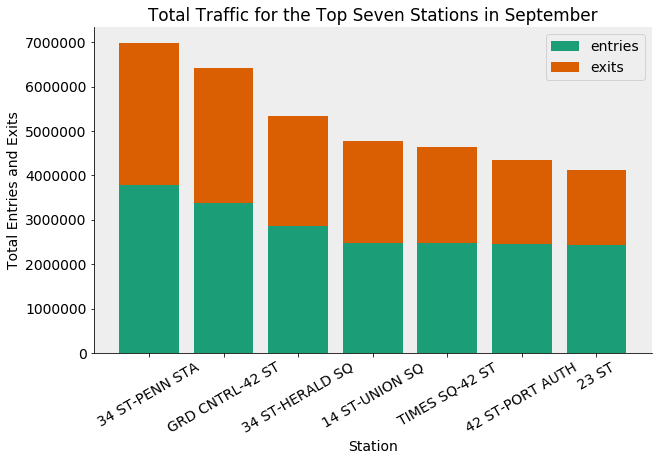

In [41]:
rcParams['figure.figsize'] = (10, 6)
rcParams['font.size'] = 14

plt.figure()
plt.bar(range(len(sorted_station_entries.index[0:7])), \
        sorted_station_entries.entries[0:7], label = 'entries',\
       tick_label = sorted_station_entries.station.iloc[0:7])

plt.bar(range(len(sorted_station_exits.index[0:7])), \
        sorted_station_exits.exits[0:7],\
        bottom = sorted_station_entries.entries[0:7],\
        tick_label = sorted_station_entries.station.iloc[0:7],\
       label = 'exits')
plt.xticks(rotation = 30)
plt.legend()
plt.xlabel('Station')
plt.ylabel('Total Entries and Exits')
plt.title('Total Traffic for the Top Seven Stations in September')
remove_border()



Now that we know which subway stations are most traversed, let's investigate the specific time of day to approach NYC citizens to maximize the number of people we can contact for the gala.

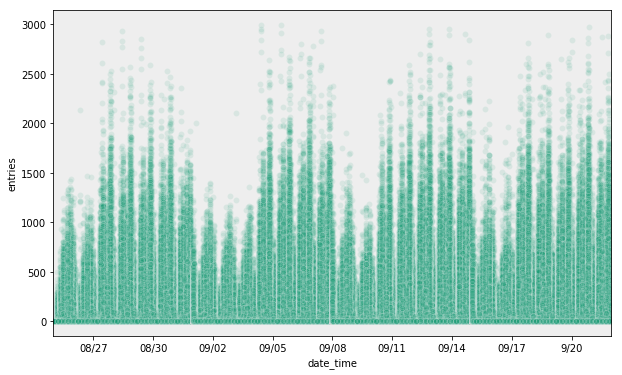

In [42]:
rcParams['figure.figsize'] = (10, 6)
rcParams['font.size'] = 10


ax = sns.scatterplot(combined_df.date_time, combined_df.entries, alpha=0.1)
plt.xlim(pd.to_datetime('2018-08-25'),pd.to_datetime('2018-09-22'))

ax.set_xticklabels(['08/27','08/30','09/02','09/05','09/08', '09/11','09/14','09/17', '9/20'])

plt.show()

Notice that nearly all of the weekdays and weekends follow the same weekly trend. 

Let's focus our analysis on the busiest stations with the highest number of entries. 

In [147]:
#just sort by entries, equivalent to total in this case

In [43]:
sorted_stations = sorted_station_entries
top_7_stations_df = combined_df.loc[combined_df['station'].isin(sorted_station_entries.station.iloc[0:7].values)]


In [44]:
top_7_stations_df.station.value_counts()

34 ST-PENN STA     16438
GRD CNTRL-42 ST    10950
23 ST              10281
34 ST-HERALD SQ     9060
42 ST-PORT AUTH     8535
TIMES SQ-42 ST      8457
14 ST-UNION SQ      6353
Name: station, dtype: int64

Looking at a box plot for the top seven stations, it is clear that an overwhelming majority of the total entries are < 500.  This is not surprising since most hours of the day people are not using the subway relgiously (think midnight to 6am).  

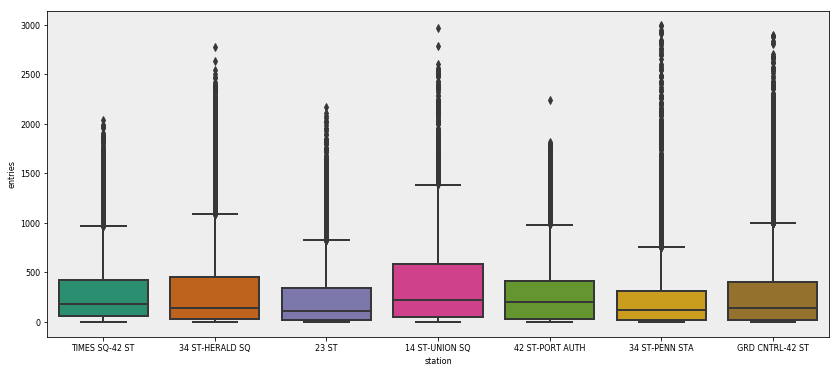

In [37]:
rcParams['figure.figsize'] = (14, 6)
rcParams['font.size'] = 8
sns.boxplot(top_7_stations_df.station, top_7_stations_df.entries)

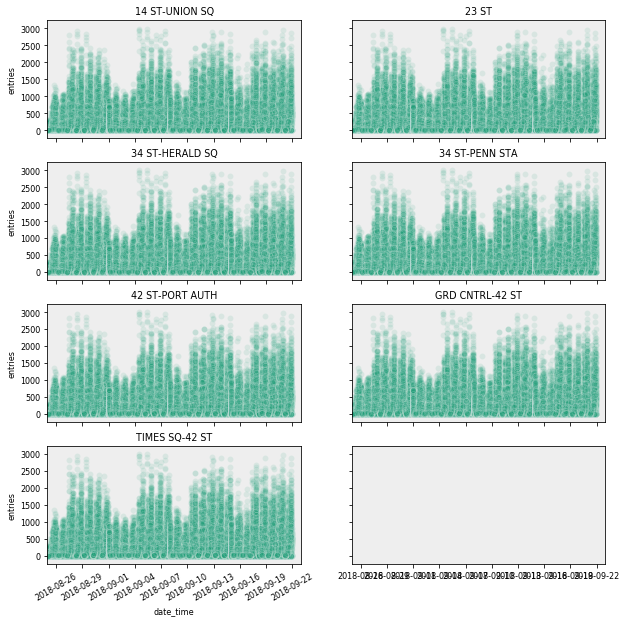

In [45]:
rcParams['font.size'] = 8
figure, subplots = plt.subplots(4, 2, sharex=True, sharey=True, figsize = (10,10))
subplots = np.ravel(subplots)
for i, (name, df) in enumerate(top_7_stations_df.groupby('station')):
    sns.scatterplot(data=top_7_stations_df, x='date_time', y='entries', ax=subplots[i], alpha = 0.1)
    subplots[i].set_xticklabels(['08/26','08/29','09/01','09/04','09/07', '09/10','09/13','09/16', '9/19','9/22' ],\
                                  rotation=30)
    subplots[i].set_title(name)
plt.xlim(pd.to_datetime('2018-08-25'),pd.to_datetime('2018-09-23'))
plt.show()

It looks like most of the plots have similar trends in their traffic. 

# Deeper Investigation into Demographics

Now that we have done some exploratory data analysis, let's investigate other sources of data to see if we can extrapolate further analysis. 

Using the website zipatlas.com, we found information on zip codes and their populations, percentage of people with over 200k, and their female to male ratio (useful since we are trying to get women involved in technology).  

In [46]:
wealthy_df = pd.read_csv('data/200k.csv', header = None)

Looking at the data frame I notice a couple of things. First, we can get rid of several columns due to meaningless data.  We should also rename our columns.

In [47]:
wealthy_df.head()

,0,1,2,3,4,5,6
0,1,10007,"40.713973, -74.008336","New York, New York","3,522",27.04%,NaN
1,2,10162,"40.769298, -73.949942","New York, New York","1,726",24.53%,NaN
2,3,10280,"40.708501, -74.016828","New York, New York","6,614",22.94%,NaN
3,4,10282,"40.717017, -74.015566","New York, New York","1,574",22.51%,NaN
4,5,10022,"40.758615, -73.967752","New York, New York","30,642",20.20%,NaN


In [48]:
#drop unnecessary columns, rename useful columns
wealthy_df = wealthy_df.drop([0, 3, 6], axis = 1)
wealthy_df.columns = ['zip', 'lat_long', 'population', 'ratio_wealthy']
#change to a float ratio
wealthy_df['ratio_wealthy'] = wealthy_df['ratio_wealthy'].apply(lambda x: float(x.replace('%', '')) * 0.01)
#make zip codes immutable
wealthy_df['zip'] = wealthy_df['zip'].apply(str)
#convert population to integers
wealthy_df['population'] = wealthy_df['population'].apply(lambda x: int(x.replace(',', '')))

In [49]:
wealthy_df.head()

,zip,lat_long,population,ratio_wealthy
0,10007,"40.713973, -74.008336",3522,0.2704
1,10162,"40.769298, -73.949942",1726,0.2453
2,10280,"40.708501, -74.016828",6614,0.2294
3,10282,"40.717017, -74.015566",1574,0.2251
4,10022,"40.758615, -73.967752",30642,0.2020


Voila. Now our data is in a much more digestible format.  Let's import a couple more data frames that include the female to male ratio and average age by zip code. 

In [51]:
age_df = pd.read_csv('data/age.csv')

In [52]:
#convert to proper data types to make computations and joins simpler
age_df['population'] = age_df['population'].apply(lambda x: int(x.replace(',', '')))
age_df['zip'] = age_df['zip'].apply(str)

In [53]:
female_df = pd.read_csv('data/female_male_ratio.csv')

In [54]:
female_df['population'] = female_df['population'].apply(lambda x: int(x.replace(',', '')))
female_df['zip'] = female_df['zip'].apply(str)

In [55]:
len(female_df)

46

In [56]:
len(age_df)

48

In [57]:
len(wealthy_df)

44

It looks like there are slight discrepancies in the counts of each of our zip code demographic data.  We can merge these data frames to see where these are. 

In [58]:
merged = female_df.merge(age_df, left_on = ['zip', 'lat_long', 'population'], \
                right_on = ['zip', 'lat_long', 'population'], how = 'outer')

In [59]:
demographics = merged.merge(wealthy_df, left_on = ['zip', 'lat_long', 'population'], \
                right_on = ['zip', 'lat_long', 'population'], how = 'outer')

In [60]:
demographics.head()

,zip,lat_long,population,f_m_ratio,avg_age,ratio_wealthy
0,10048,"40.711665, -74.012417",55,3.23,21.3,NaN
1,10037,"40.813159, -73.937352",16984,1.42,39.8,0.0081
2,10021,"40.769742, -73.961653",102078,1.28,39.9,0.1905
3,10039,"40.826296, -73.937053",21737,1.27,32.3,0.0059
4,10162,"40.769298, -73.949942",1726,1.22,41.0,0.2453


In [61]:
demographics.tail()

,zip,lat_long,population,f_m_ratio,avg_age,ratio_wealthy
43,10005,"40.705390, -74.008988",884,0.67,28.3,0.0964
44,10007,"40.713973, -74.008336",3522,0.59,34.4,0.2704
45,10020,"40.758236, -73.978833",1,0.00,28.5,NaN
46,10170,"40.752625, -73.975877",1,NaN,49.5,NaN
47,10171,"40.755899, -73.973858",1,NaN,48.5,NaN


It looks like certain zip codes do not have information due to the population size being so small. This is okay since we do not want to fundraise around zip codes with such few people. Let's drop 'em.

In [62]:
demographics = demographics.dropna()

# Combining Demographic Data and Station Data

In [63]:
grouped_by_station.sort_values('entries', ascending = False).head()

,station,entries,exits,morning,morning_entries,afternoon_entries
59,34 ST-PENN STA,3789571.0,3197859.0,10397,1893647.0,1895838.0
229,GRD CNTRL-42 ST,3371320.0,3054932.0,6421,1031715.0,2171571.0
57,34 ST-HERALD SQ,2862311.0,2484405.0,6076,851219.0,1332042.0
14,14 ST-UNION SQ,2473995.0,2166529.0,3157,555006.0,1918989.0
349,TIMES SQ-42 ST,2470139.0,2294915.0,5643,1021351.0,1312630.0


In [65]:
station_zip = pd.read_csv('data/top50sta_zipcodesUpdated.csv')
station_zip.columns = [col.lower().strip()\
                             for col in station_zip.columns]
station_zip['zip'] = station_zip['zip'].apply(str)
station_zip = station_zip.drop(['unnamed: 0'], axis = 1)

In [66]:
station_zip.head()

,station,linename,entries,exits,total,zip
0,GRD CNTRL-42 ST,4567S,3371320,3054932,6426252,10017
1,34 ST-HERALD SQ,BDFMNQRW,2862311,2484405,5346716,10001
2,42 ST-PORT AUTH,ACENQRS1237W,2138638,1395893,3534531,10036
3,34 ST-PENN STA,ACE,1874451,1661838,3536289,10001
4,14 ST-UNION SQ,LNQR456W,1733708,1510138,3243846,10003


Let's group our final demographic data together.

In [67]:
final_demo = grouped_by_station.merge(station_zip, left_on = ['station'], \
                right_on = ['station'], how = 'outer' )

In [397]:
final_demo = final_demo.dropna()

In [68]:
final_demo.head()

,station,entries_x,exits_x,morning,morning_entries,afternoon_entries,linename,entries_y,exits_y,total,zip
0,1 AV,504631.0,555406.0,1120,240550.0,264081.0,NaN,NaN,NaN,NaN,NaN
1,103 ST,708860.0,499253.0,1266,205236.0,503624.0,NaN,NaN,NaN,NaN,NaN
2,103 ST-CORONA,465033.0,340062.0,1017,316729.0,148304.0,NaN,NaN,NaN,NaN,NaN
3,104 ST,71720.0,19304.0,999,34677.0,13011.0,NaN,NaN,NaN,NaN,NaN
4,110 ST,245731.0,210946.0,672,132160.0,113571.0,NaN,NaN,NaN,NaN,NaN


Let's only include one entries, exits, and totals column.

In [69]:
final_demo = final_demo.drop(['entries_y', 'exits_y', 'total'], axis = 1)

Merge on our demographic information to link to each station.

In [70]:
final_demo = final_demo.merge(demographics, left_on = ['zip'], \
                right_on = ['zip'], how = 'outer')

In [71]:
final_demo = final_demo.dropna()

In [72]:
final_demo = final_demo.drop(['lat_long'], axis = 1)

In [73]:
final_demo.head(6)

,station,entries_x,exits_x,morning,morning_entries,afternoon_entries,linename,zip,population,f_m_ratio,avg_age,ratio_wealthy
331,125 ST,1880139.0,1521310.0,4293.0,673779.0,1098944.0,ACBD,10027,56168.0,1.10,30.9,0.0185
332,125 ST,1880139.0,1521310.0,4293.0,673779.0,1098944.0,456,10035,32702.0,1.02,32.4,0.0052
333,14 ST-UNION SQ,2473995.0,2166529.0,3157.0,555006.0,1918989.0,LNQR456W,10003,53673.0,1.06,33.7,0.1091
334,14 ST-UNION SQ,2473995.0,2166529.0,3157.0,555006.0,1918989.0,456LNQRW,10003,53673.0,1.06,33.7,0.1091
335,23 ST,2427563.0,1703664.0,5967.0,648589.0,1664584.0,6,10010,26408.0,1.19,37.6,0.1031
336,23 ST,2427563.0,1703664.0,5967.0,648589.0,1664584.0,NRW,10010,26408.0,1.19,37.6,0.1031


Include a ratio that reflects the morning entries versus the afternoon entries.  The higher this is, the more likely we are to target key demographics in the morning. 

In [74]:
final_demo['morn_aft_ent_ratio'] = final_demo.morning_entries /\
final_demo.afternoon_entries

In [75]:
final_demo.head()

,station,entries_x,exits_x,morning,morning_entries,afternoon_entries,linename,zip,population,f_m_ratio,avg_age,ratio_wealthy,morn_aft_ent_ratio
331,125 ST,1880139.0,1521310.0,4293.0,673779.0,1098944.0,ACBD,10027,56168.0,1.10,30.9,0.0185,0.613115
332,125 ST,1880139.0,1521310.0,4293.0,673779.0,1098944.0,456,10035,32702.0,1.02,32.4,0.0052,0.613115
333,14 ST-UNION SQ,2473995.0,2166529.0,3157.0,555006.0,1918989.0,LNQR456W,10003,53673.0,1.06,33.7,0.1091,0.289218
334,14 ST-UNION SQ,2473995.0,2166529.0,3157.0,555006.0,1918989.0,456LNQRW,10003,53673.0,1.06,33.7,0.1091,0.289218
335,23 ST,2427563.0,1703664.0,5967.0,648589.0,1664584.0,6,10010,26408.0,1.19,37.6,0.1031,0.389640


Now that we have our zipcodes, demographic information, and stations all in the same data frame, we can do some additional analysis.  

Let's create a data frame that computes a score that encompasses the morning to afternoon entry ratio, female to male ratio, and the ratio of wealthy people.  We can normalize each of these factors so that our final "score" is all on a similar scale.

In [76]:

final_demo['fm_norm'] = final_demo.f_m_ratio / \
        (final_demo.f_m_ratio.max() - final_demo.f_m_ratio.min())
    
final_demo['wealth_norm'] = final_demo.ratio_wealthy / \
        (final_demo.ratio_wealthy.max() - final_demo.ratio_wealthy.min())
    
final_demo['age_norm'] = final_demo.avg_age / \
        (final_demo.avg_age.max() - final_demo.avg_age.min())

In [78]:
final_demo['score'] = final_demo.morn_aft_ent_ratio * \
                         final_demo.fm_norm * \
                         final_demo.wealth_norm * \
                         final_demo.age_norm

In [79]:
#normalize to a scale of 0-10
old_min = 0.011134
old_max = 3.685918  
old_range = old_max - old_min
new_range = 10
final_demo['score_norm'] = (((final_demo.score - old_min) * new_range) / (3.685918 - 0.011134) ) 

Now we have a scoring system that goes from 0 to 10 and is directly proportional to the population, female to male ratio, average age, and ratio of wealthy denizes.  Let's see the top stations by ranking. 

In [82]:
final_demo.sort_values(['score_norm'], ascending = False).head(5)

,station,entries_x,exits_x,morning,morning_entries,afternoon_entries,linename,zip,population,f_m_ratio,avg_age,ratio_wealthy,morn_aft_ent_ratio,fm_norm,wealth_norm,age_norm,score,score_norm
357,86 ST,1741953.0,1589549.0,4787.0,696926.0,1045027.0,456,10028,44987.0,1.21,38.3,0.1884,0.666898,1.753623,0.710407,2.623288,2.179459,5.900551
358,86 ST-2 AVE,594669.0,393410.0,1267.0,200470.0,394199.0,Q,10028,44987.0,1.21,38.3,0.1884,0.508550,1.753623,0.710407,2.623288,1.661971,4.492338
349,LEXINGTON AV/53,881999.0,894326.0,3604.0,212144.0,551177.0,EM6,10022,30642.0,1.19,45.5,0.2020,0.384893,1.724638,0.761689,3.116438,1.575701,4.257577
350,50 ST,1137591.0,868242.0,4031.0,479617.0,657974.0,1,10019,36012.0,0.98,37.0,0.1189,0.728930,1.420290,0.448341,2.534247,1.176305,3.170720
355,72 ST-2 AVE,669590.0,581507.0,1428.0,157243.0,512347.0,Q,10021,102078.0,1.28,39.9,0.1905,0.306907,1.855072,0.718326,2.732877,1.117659,3.011131


It looks like there is significant variation in comparison to our stations with the highest traffic.  It looks like we will be faced with a major tradeoff since we cannot kill two birds with one stone: spend more resources on filling the gala using the busy station vs targeting certain demographics at specified locations based on our scoring system.  Let's invesitgate the ROI for both methods. 

## Time Series Analysis

Now we have a data frame without our most highly-trafficked stations, a data frame with zip code and demographic information, as well as our original combined data frame which contains all of the original cleaned data. Let's start investigating the time component of the project. 

Since we are integrating demographic information into our analyses, we want to target people where they reside.  Thus, we should focus on entries in the morning and exits in the evening (think going to and from work). 

Let's find the day and the type of day to understand the behavior between certain days and the difference in subway use for weekdays vs weekends. 

In [84]:
combined_df['day'] = combined_df['date_time'].dt.weekday_name
combined_df['type_of_day'] = np.where((combined_df['day']=='Saturday') | \
                                      (combined_df['day']=='Sunday'),'weekend', 'weekday')

Also, since one of our approaches is purely based on traffic at each station, let's create another column that includes total entries and exits. 

In [86]:
combined_df['total'] = combined_df.entries + combined_df.exits

In [ ]:
# IMAGE2

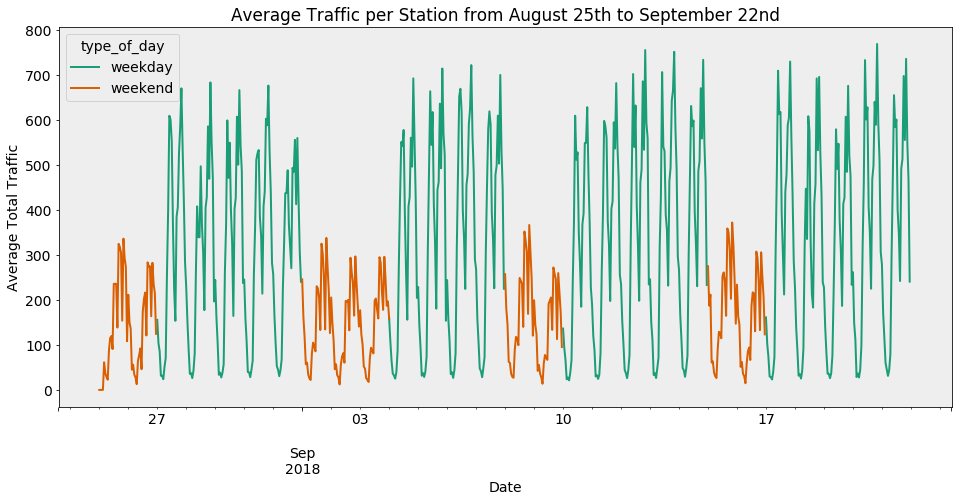

In [122]:
rcParams['figure.figsize'] = (16, 7)
rcParams['font.size'] = 14
plot = combined_df.groupby(['date_time', 'type_of_day']).mean()['total'].unstack().plot()
plt.xlabel('Date')
plt.ylabel('Average Total Traffic')
plt.title('Average Traffic per Station from August 25th to September 22nd')
plt.savefig('images/fig1.jpg')
plt.show()


In [416]:
#IMAGE3

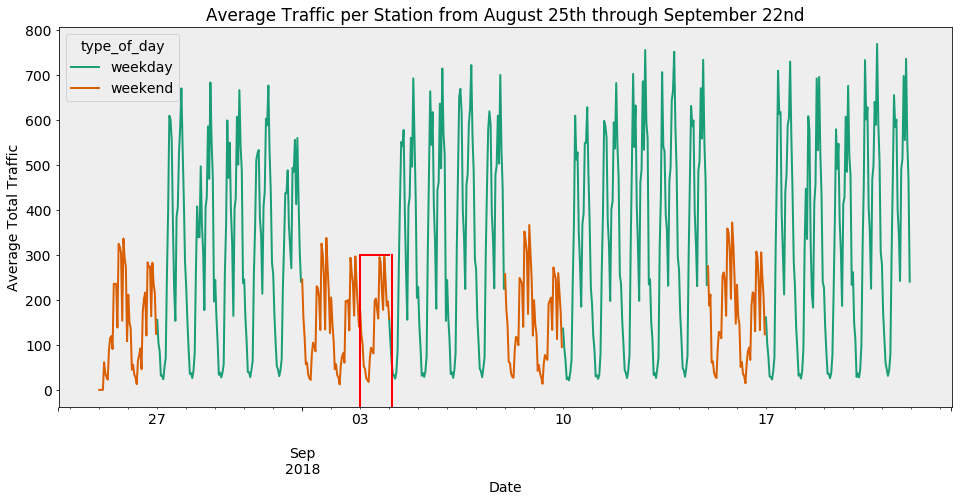

In [123]:
rcParams['figure.figsize'] = (16, 7)
rcParams['font.size'] = 14
plot = combined_df.groupby(['date_time', 'type_of_day']).mean()['total'].unstack().plot()
plt.xlabel('Date')
plt.ylabel('Average Total Traffic')
plt.title('Average Traffic per Station from August 25th through September 22nd')


plot.axvline(pd.to_datetime('09-03-2018 00:00:00'), 0, 0.4, color='r', linewidth = 2)
plot.axvline(pd.to_datetime('09-04-2018 02:40:00'), 0, 0.4, color='r', linewidth = 2)
plot.axhline(300, 0.34, 0.37, color='r', linewidth = 2)
plt.savefig('images/fig2.jpg')
plt.show()

Notice the clear difference between weekdays and weekends, except for the portion blocked off by the red square. This anomaly is Labor Day. Since it's behavior is much akin to weekends, let's group it with the weekends rather than the weekdays when performing analyses to distinguish between weekdays and weekends. 

In [89]:
combined_df[combined_df.date == '09/03/2018']['type_of_day'] = 'weekend'

In [90]:
#same as before but include the additional check on the date
combined_df['type_of_day'] = np.where((combined_df['day']=='Saturday') | \
                                      (combined_df['day']=='Sunday') | (combined_df['date'] == '09/03/2018'),\
                                      'weekend', 'weekday')

Let's make sure the change is reflected in our graph. 

In [ ]:
#IMAGE4

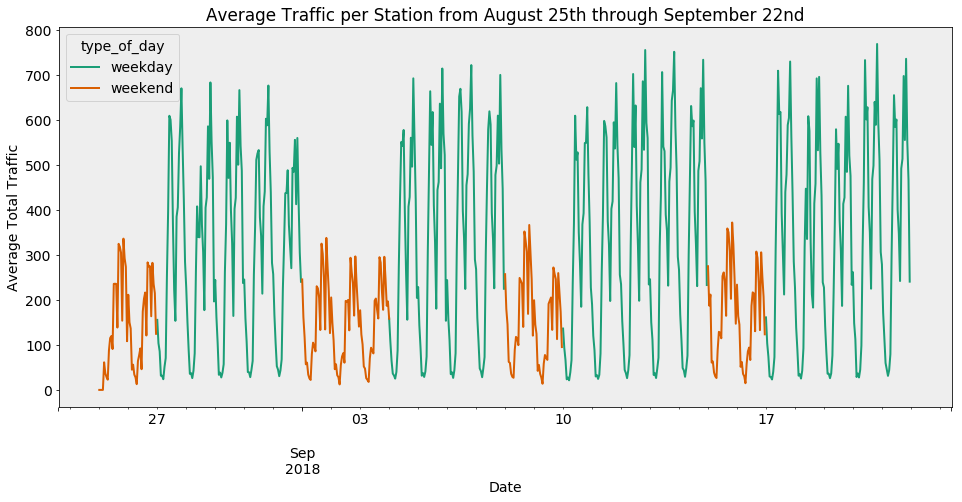

In [121]:
rcParams['figure.figsize'] = (16, 7)
rcParams['font.size'] = 14
plot = combined_df.groupby(['date_time', 'type_of_day']).mean()['total'].unstack().plot()
plt.xlabel('Date')
plt.ylabel('Average Total Traffic')
plt.title('Average Traffic per Station from August 25th through September 22nd')
plt.savefig('images/fig3.jpg')
plt.show()

In [92]:
#differentiate between weekends and weekdays
weekend_df = combined_df[combined_df.type_of_day == 'weekend']
weekday_df = combined_df[combined_df.type_of_day == 'weekday']


In [93]:
#convert time to a datetime object and the index so we can plot it as a time series plot
weekend_df['time'] = weekend_df['time'].apply(lambda x: pd.to_datetime(x))
weekday_df['time'] = weekday_df['time'].apply(lambda x: pd.to_datetime(x))
weekend_df.set_index('time', inplace = True)
weekday_df.set_index('time', inplace = True)

Let's check whether the difference in subway patterns between weekdays and weekends for entries. 

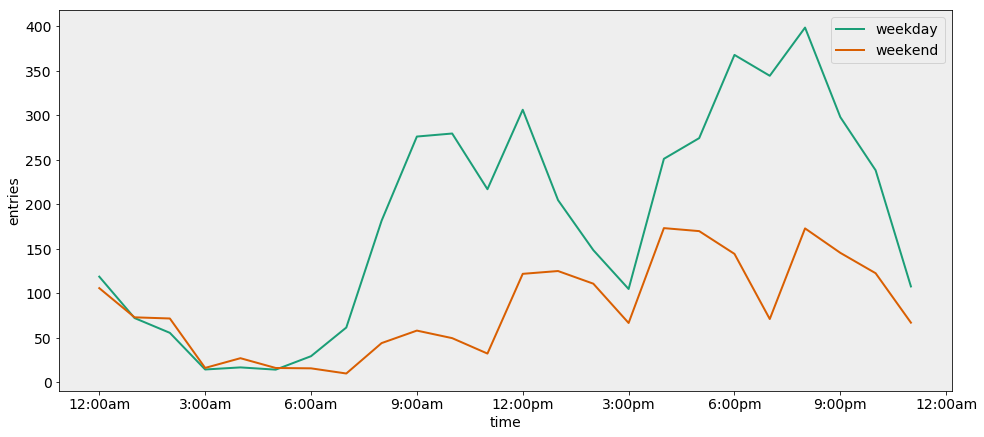

In [94]:
plot = sns.lineplot(x = weekday_df.resample('h').mean().index,\
             y = weekday_df.resample('h').mean().entries, \
             label = 'weekday')

sns.lineplot(x = weekend_df.resample('h').mean().index,\
                    y = weekend_df.resample('h').mean().entries, \
                    label = 'weekend')

plot.set_xticklabels(['12:00am','3:00am', '6:00am','9:00am', '12:00pm', \
                      '3:00pm', '6:00pm', '9:00pm', '12:00am'])

plt.show()

Let's check whether the difference in subway patterns between weekdays and weekends for exits. 

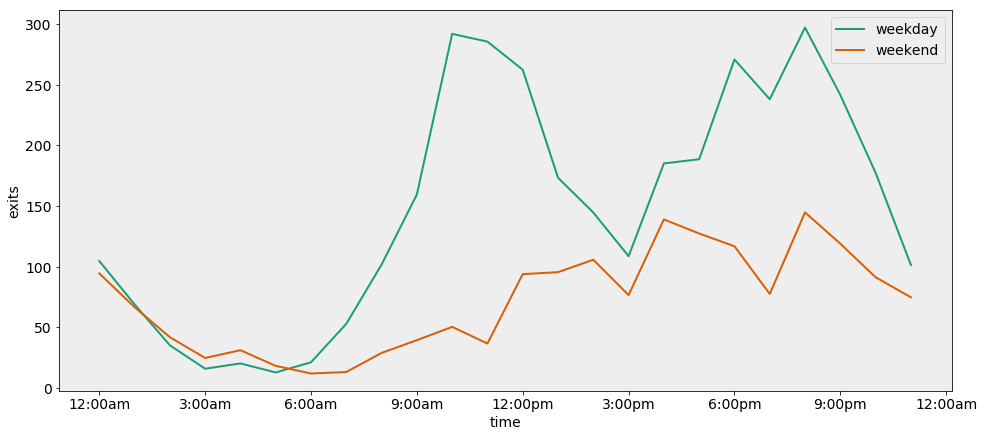

In [95]:
plot = sns.lineplot(x = weekday_df.resample('h').mean().index,\
             y = weekday_df.resample('h').mean().exits, \
             label = 'weekday')

sns.lineplot(x = weekend_df.resample('h').mean().index,\
                    y = weekend_df.resample('h').mean().exits, \
                    label = 'weekend')

plot.set_xticklabels(['12:00am','3:00am', '6:00am','9:00am', '12:00pm', \
                      '3:00pm', '6:00pm', '9:00pm', '12:00am'])

plt.show()

Instead of looking at all of the stations combined, let's filter out the top seven stations when it comes to overall traffic. 

## Top Seven Stations Time Series Analysis

Let's do the same analysis as before but focus on the top seven station with respect to traffic.  This will ensure the traffic patterns are more precise and we can more accurately quantify the impact of going to these stations at specific times. 

In [96]:
top_7_stations_df['day'] = top_7_stations_df['date_time'].dt.weekday_name

In [97]:
top_7_stations_df['type_of_day'] = np.where((top_7_stations_df['day']=='Saturday') | \
                                      (top_7_stations_df['day']=='Sunday') | \
                                              (top_7_stations_df['date'] == '09/03/2018')\
                                      ,'weekend', 'weekday')

In [98]:
combined_df.describe()

,entries,exits,morning,morning_entries,afternoon_entries,total
count,786362.000000,786362.000000,786362.000000,786362.00000,786362.000000,786362.000000
mean,168.697342,130.486014,0.587455,66.74013,96.955800,299.183356
std,247.764446,218.157728,0.492293,168.02452,218.538602,375.105636
min,0.000000,0.000000,0.000000,-2775.00000,-2255.000000,0.000000
25%,9.000000,8.000000,0.000000,0.00000,0.000000,28.000000
50%,70.000000,50.000000,1.000000,0.00000,0.000000,162.000000
75%,229.000000,158.000000,1.000000,49.00000,104.000000,434.000000
max,2995.000000,2999.000000,1.000000,2995.00000,2967.000000,4884.000000


In [99]:
top_7_stations_df.describe()

,entries,exits,morning,morning_entries,afternoon_entries
count,70074.000000,70074.000000,70074.000000,70074.000000,70074.000000
mean,283.242044,236.890402,0.611810,99.612995,160.641607
std,367.366044,341.653771,0.487342,242.851377,347.101188
min,0.000000,0.000000,0.000000,-2775.000000,-2255.000000
25%,27.000000,23.000000,0.000000,0.000000,0.000000
50%,149.000000,112.000000,1.000000,4.000000,0.000000
75%,396.000000,311.000000,1.000000,103.000000,209.000000
max,2995.000000,2999.000000,1.000000,2995.000000,2967.000000


Some quick interesting tidbits: the top ten stations make up about 1.5% of the stations and 10% of the total entries and exits. Also, the mean entires and exits is significantly larger than the average of the entire data frame.

In [100]:
top_7_stations_df['total'] = top_7_stations_df.entries + top_7_stations_df.exits

In [101]:
weekend_df_7 = top_7_stations_df[top_7_stations_df.type_of_day == 'weekend']
weekday_df_7 = top_7_stations_df[top_7_stations_df.type_of_day == 'weekday']

In [102]:
weekend_df_7['time'] = weekend_df_7['time'].apply(lambda x: pd.to_datetime(x))
weekday_df_7['time'] = weekday_df_7['time'].apply(lambda x: pd.to_datetime(x))
weekend_df_7.set_index('time', inplace = True)
weekday_df_7.set_index('time', inplace = True)

In [ ]:
#IMAGE5

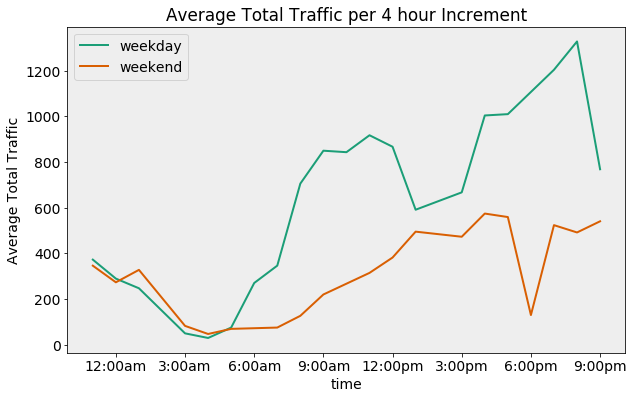

In [103]:
rcParams['figure.figsize'] = (10, 6)
rcParams['font.size'] = 14

plot = sns.lineplot(x = weekday_df_7.resample('h').mean().index,\
                    y = weekday_df_7.resample('h').mean().total, \
                    label = 'weekday')

sns.lineplot(x = weekend_df_7.resample('h').mean().index,\
             y = weekend_df_7.resample('h').mean().total,\
             label = 'weekend')


plot.set_xticklabels(['12:00am','3:00am', '6:00am','9:00am', '12:00pm', \
                      '3:00pm', '6:00pm', '9:00pm', '12:00pm'])

#plot.axvline(pd.to_datetime('19:00:00'), 0, 1, color='r',linestyle = '--', linewidth = 2)
#plot.axvline(pd.to_datetime('21:00:00'), 0, 1, color='r',linestyle = '--', linewidth = 2)
plt.ylabel('Average Total Traffic')
plt.title('Average Total Traffic per 4 hour Increment')

plt.show()

Same plot above but with dashed red markers to denote peak traffic:

In [ ]:
#IMAGE6

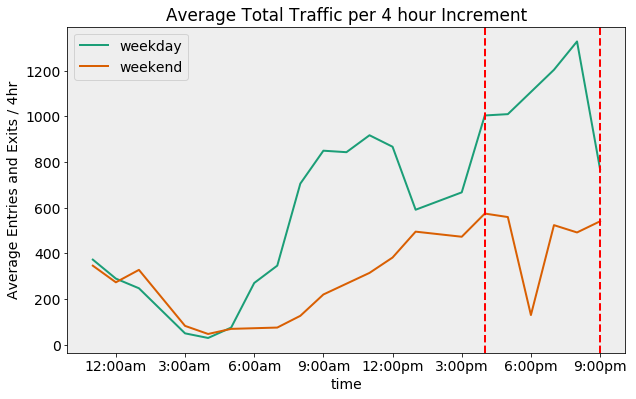

In [106]:
plot = sns.lineplot(x = weekday_df_7.resample('h').mean().index,\
                    y = weekday_df_7.resample('h').mean().total, \
                    label = 'weekday')

sns.lineplot(x = weekend_df_7.resample('h').mean().index,\
             y = weekend_df_7.resample('h').mean().total,\
             label = 'weekend')

plot.set_xticklabels(['12:00am','3:00am', '6:00am','9:00am', '12:00pm', \
                      '3:00pm', '6:00pm', '9:00pm', '12:00pm'])


plt.ylabel('Average Total Traffic')
plt.title('Average Total Traffic per 4 hour Increment')

plot.axvline(pd.to_datetime('2018-09-28 17:00:00'), 0, 1, color='r',linestyle = '--', linewidth = 2)
plot.axvline(pd.to_datetime('2018-09-28 22:00:00'), 0, 1, color='r',linestyle = '--', linewidth = 2)
plt.ylabel('Average Entries and Exits / 4hr')
plt.show()

# DEMOGRAPHIC ANALYSIS

I plan on using some of the code below to single out certain stations based on our demographic analyses.

In [107]:
demo_1 = combined_df[combined_df.station == '86 ST']
demo_2 = combined_df[combined_df.station == '86 ST-2 AVE']
demo_3 = combined_df[combined_df.station == 'LEXINGTON AV/53']
demo_4 = combined_df[combined_df.station == '72 ST-2 AVE']
#got rid of number 5 to make our figure look better
#demo_5 = combined_df[combined_df.station == '72 ST']




In [108]:
top4_demo = pd.concat([demo_1, demo_2, demo_3, demo_4])

In [110]:
top4_demo['day'] = top4_demo['date_time'].dt.weekday_name

In [111]:
top4_demo['type_of_day'] = np.where((top4_demo['day']=='Saturday') | \
                                      (top4_demo['day']=='Sunday') | \
                                              (top4_demo['date'] == '09/03/2018')\
                                      ,'weekend', 'weekday')

In [112]:
weekend_top4_demo = top4_demo[top4_demo.type_of_day == 'weekend']
weekday_top4_demo = top4_demo[top4_demo.type_of_day == 'weekday']


In [113]:
weekend_top4_demo['time'] = weekend_top4_demo['time'].apply(lambda x: pd.to_datetime(x))
weekday_top4_demo['time'] = weekday_top4_demo['time'].apply(lambda x: pd.to_datetime(x))


In [114]:
weekend_top4_demo.set_index('time', inplace = True)
weekday_top4_demo.set_index('time', inplace = True)

In [116]:
weekday_top4_demo.head()

,c/a,unit,scp,station,linename,division,date,entries,exits,morning,morning_entries,afternoon_entries,date_time,day,type_of_day,total
time,,,,,,,,,,,,,,,,
2018-09-28 00:00:00,C025,R215,00-00-00,86 ST,R,BMT,08/27/2018,0.0,0.0,1,0.0,0.0,2018-08-27 00:00:00,Monday,weekday,0.0
2018-09-28 04:00:00,C025,R215,00-00-00,86 ST,R,BMT,08/27/2018,0.0,0.0,1,0.0,0.0,2018-08-27 04:00:00,Monday,weekday,0.0
2018-09-28 08:00:00,C025,R215,00-00-00,86 ST,R,BMT,08/27/2018,567.0,40.0,1,567.0,0.0,2018-08-27 08:00:00,Monday,weekday,607.0
2018-09-28 12:00:00,C025,R215,00-00-00,86 ST,R,BMT,08/27/2018,602.0,111.0,1,602.0,0.0,2018-08-27 12:00:00,Monday,weekday,713.0
2018-09-28 16:00:00,C025,R215,00-00-00,86 ST,R,BMT,08/27/2018,364.0,142.0,0,0.0,364.0,2018-08-27 16:00:00,Monday,weekday,506.0


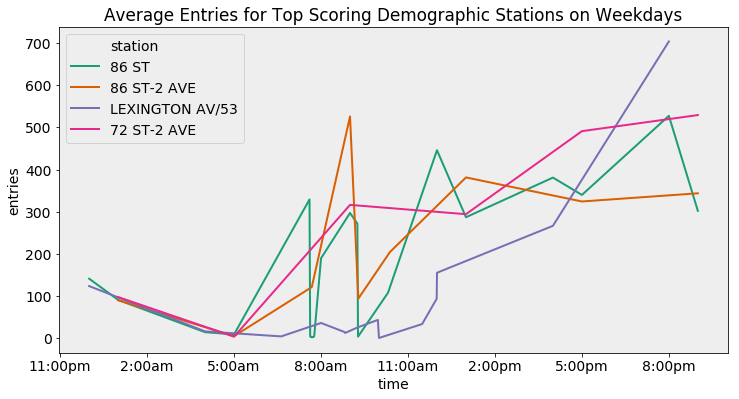

In [118]:
rcParams['figure.figsize'] = (12, 6)
rcParams['font.size'] = 14

plot = sns.lineplot(x = weekday_top4_demo.index,\
                    y = weekday_top4_demo.entries,\
                   hue = weekday_top4_demo.station, \
                    ci = None)

#plot.axvline(pd.to_datetime('2018-09-28 21:00:00'), 0, 1, color='r',linestyle = '--', linewidth = 2)
#plot.axvline(pd.to_datetime('2018-09-28 00:00:00'), 0, 1, color='r',linestyle = '--', linewidth = 2)
plt.legend(loc = 'upper_left')
plt.title('Average Entries for Top Scoring Demographic Stations on Weekdays')
plot.set_xticklabels(['11:00pm','2:00am', '5:00am','8:00am', '11:00am', \
                      '2:00pm', '5:00pm', '8:00pm', '11:00pm', '6:00pm', \
                      '8:00pm', '10:00pm'])
plt.show()